In [10]:
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt

In [174]:
#load the sample audio file as a floating point time series
filename = 'Small_audio_sample/118960_mole.wav'
chirp_song, sr = librosa.load(filename)

In [175]:
#Compute a short-time Fourier transform (stft) column matrix M with complex entries, starting three-fourths of the way into the file
n_fft = 2048
sample_start = int(chirp_song.shape[0]*.75)
M = librosa.stft(chirp_song[sample_start:sample_start+n_fft], n_fft=n_fft, hop_length=n_fft+1)

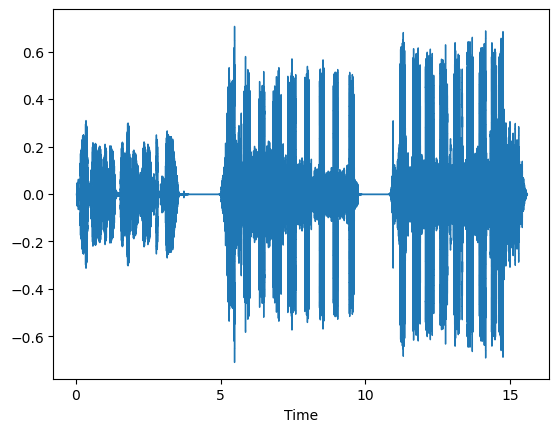

In [176]:
#visualize the waveform as a function of time
librosa.display.waveshow(chirp_song, sr=sr);

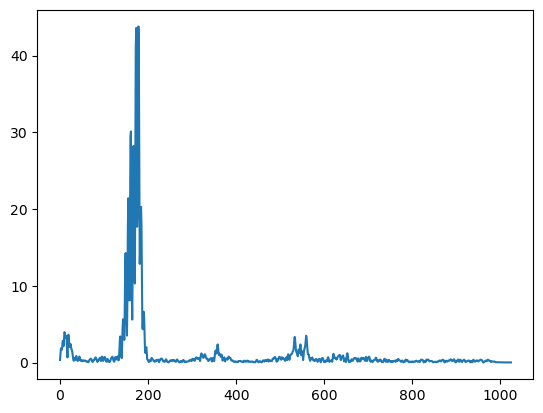

In [177]:
#Plot the absolute value of the entries (the spectromgram)
plt.plot(abs(M))

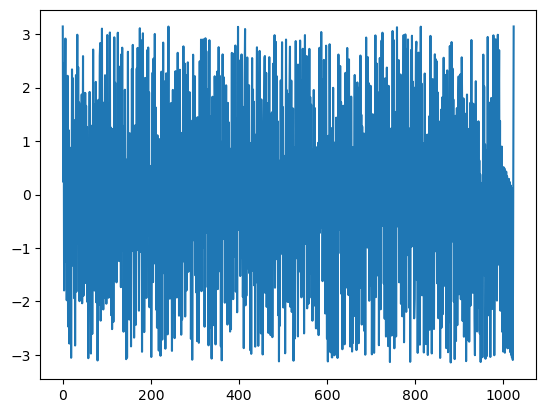

In [178]:
#Plot the phase (=angle) of entries
plt.plot(np.angle(M))

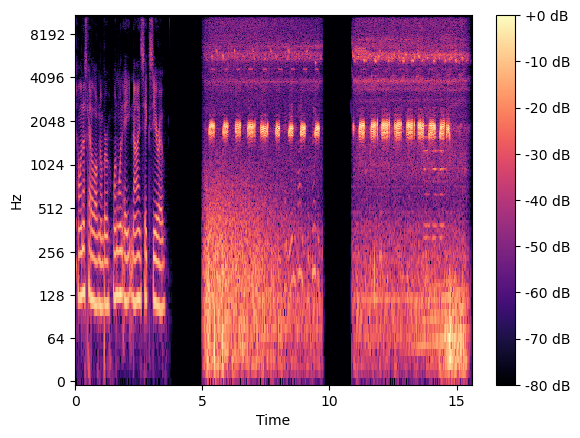

In [179]:
#The Mel spectrogram
#Divide the file into small segments and apply the stft to each. Then along each vertical segment, plot the volume (dB) at each corresponding pitch (Hz) 
hop_length = 512
n_fft = 2048
D = np.abs(librosa.stft(chirp_song, n_fft=n_fft,  hop_length=hop_length))
DB = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');

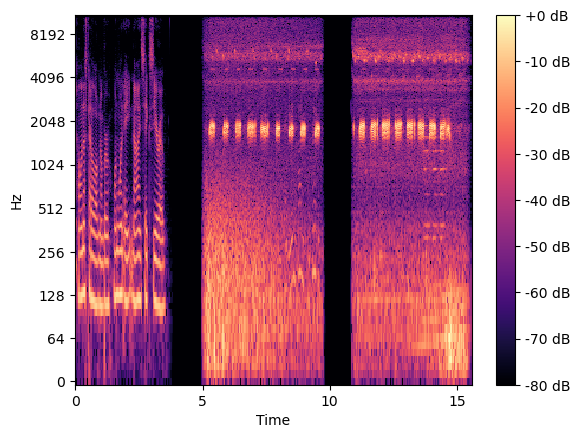

In [180]:
#same but more samples(=hop_length) between each column (so less computation)
hop_length = 1024
n_fft = 2048
D = np.abs(librosa.stft(chirp_song, n_fft=n_fft,  hop_length=hop_length))
DB = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');

In [181]:
#Robert: This code comes directly from https://librosa.org/librosa_gallery/auto_examples/plot_vocal_separation.html
S_full, phase = librosa.magphase(librosa.stft(chirp_song))

In [182]:
# We'll compare frames using cosine similarity, and aggregate similar frames
# by taking their (per-frequency) median value.
#
# To avoid being biased by local continuity, we constrain similar frames to be
# separated by at least 2 (Robert: 2 won't run on the small audio samples) seconds.
#
# This suppresses sparse/non-repetetitive deviations from the average spectrum,
# and works well to discard vocal elements.

S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr)))

# The output of the filter shouldn't be greater than the input
# if we assume signals are additive.  Taking the pointwise minimium
# with the input spectrum forces this.
S_filter = np.minimum(S_full, S_filter)

In [183]:
# We can also use a margin to reduce bleed between the vocals and instrumentation masks.
# Note: the margins need not be equal for foreground and background separation
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

# Once we have the masks, simply multiply them with the input spectrum
# to separate the components

S_foreground = mask_v * S_full
S_background = mask_i * S_full

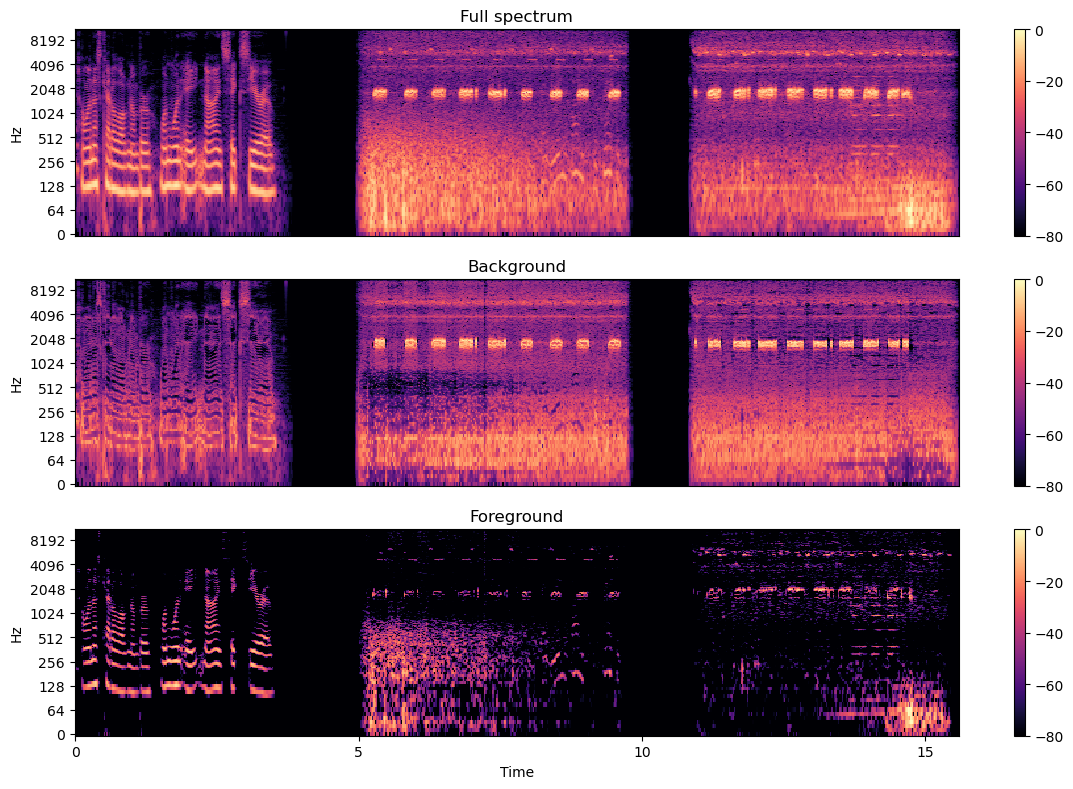

In [184]:
# sphinx_gallery_thumbnail_number = 2

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(S_full, ref=np.max),
                         y_axis='log', sr=sr)
plt.title('Full spectrum')
plt.colorbar()

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(S_background, ref=np.max),
                         y_axis='log', sr=sr)
plt.title('Background')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(S_foreground, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('Foreground')
plt.colorbar()
plt.tight_layout()
plt.show()

In [185]:
#Here we use a librosa function to split the audio file into non-silent intervals
split=librosa.effects.split(chirp_song, top_db=60)
chirp_song_split=chirp_song[split[1,0]:split[1,1]]
split

array([[     0,  82944],
       [109056, 217088],
       [238080, 343809]])

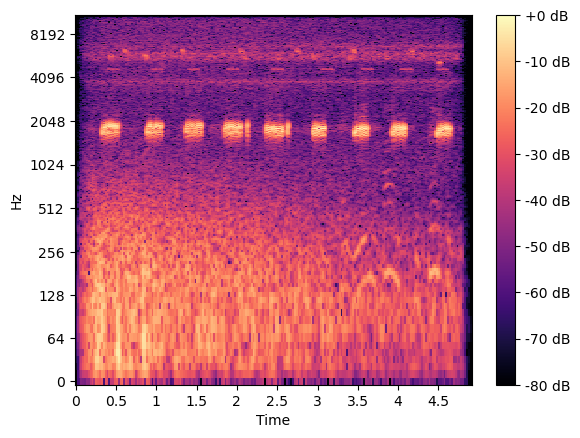

In [187]:
#The Mel spectrogram of the second non-silent interval 
hop_length = 512
n_fft = 2048
D = np.abs(librosa.stft(chirp_song_split, n_fft=n_fft,  hop_length=hop_length))
DB = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');

93696